In [1]:
import pickle
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import cv2
from PIL import Image
import numpy as np
import torchvision.transforms as T
from Viz import UNet_Attention , load_checkpoint
from SegtUtils import Preprocessing , segmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
def plot_maps(att):
    feature_map = att.squeeze(0)

    gray_scale = torch.mean(feature_map,0)
    print(gray_scale.shape)

    gray_scale=gray_scale.data.cpu().numpy()


    gray_scale=(gray_scale - np.min(gray_scale)) / (np.max(gray_scale) - np.min(gray_scale))

    return gray_scale



def plot_map(path , model,transform,DEVICE,layer,save):
    image = np.array(cv2.imread(path))
    image = transform(image=image)["image"]
    model.eval()
    with torch.no_grad():
        x = image.float().unsqueeze(0).to(DEVICE)
        out , x4 , x3 , x2 ,x1,d2 = model(x)
        out = torch.sigmoid(out)
        out = (out > 0.5).float()
    if layer == 'out':
        heatmap = plot_maps(out)
    elif layer == 'x4':
        heatmap = plot_maps(x4)
    elif layer == 'x3':
        heatmap = plot_maps(x3)
    elif layer == 'x2':
        heatmap = plot_maps(x2)
    elif layer == 'x1':
        heatmap = plot_maps(x1)
    elif layer == 'd2':
        heatmap = plot_maps(d2)
    img = cv2.imread(path)
    img = cv2.resize(img,(512,256))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img=cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
    cv2.imwrite(f'./{save}.jpg', heatmap)
    plot1 = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    plot2= cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2)

    # Plot the first image on the first subplot
    axs[0].imshow(plot1)
    axs[0].set_title('Overlay')

    # Plot the second image on the second subplot
    heatmap_plot =axs[1].imshow(plot2, cmap='jet')
    axs[1].set_title('CAM')


    plt.colorbar(heatmap_plot,ax=axs[1])

    plt.axis("on")

    # Adjust spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()


torch.Size([128, 256])


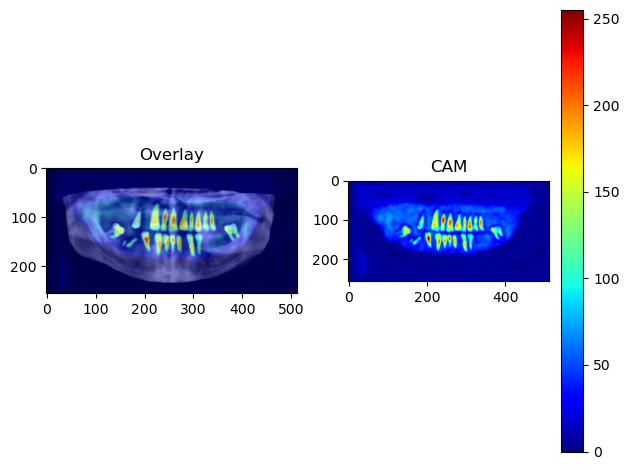

In [14]:
plot_map('../data/val/Images/12.JPG',model,val_transforms,DEVICE,'d2',5)

# Metric Plotting & Analysis

In [3]:
dfPA = pd.read_csv('./CSVs/PA.csv')
dfIoU = pd.read_csv('./CSVs/IoU.csv')
dfDice = pd.read_csv('./CSVs/Dice.csv')

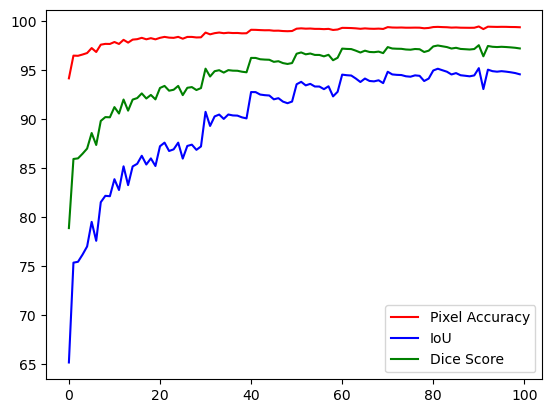

<Figure size 800x600 with 0 Axes>

In [6]:
plt.plot(dfPA['Step'], dfPA['Value'],color='red',label='Pixel Accuracy')
plt.plot(dfIoU['Step'], dfIoU['Value'],color='blue',label='IoU')
plt.plot(dfDice['Step'], dfDice['Value'],color='green',label='Dice Score')

plt.legend()

# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Combined Plot')
plt.figure(figsize=(8, 6))

plt.show()

In [95]:
def plot_metrics(df,name,color):
    plt.plot(df['Step'], df['Value'],color=color)

    # Set labels for the x and y axes
    plt.xlabel('Step')
    plt.ylabel('Value')

    # Set a title for the plot
    plt.title(name)

    # Display the plot
    plt.show()

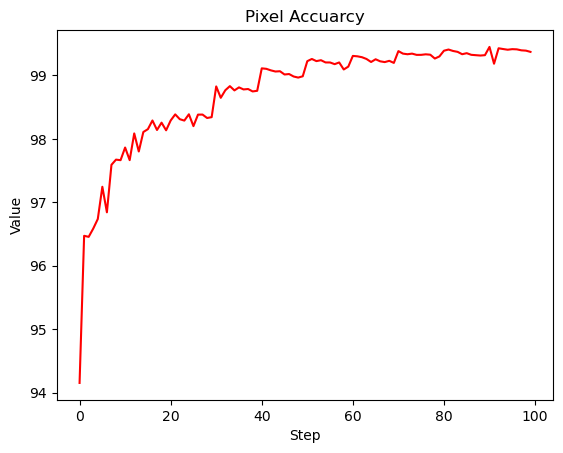

In [96]:
plot_metrics(dfPA,'Pixel Accuarcy','red')

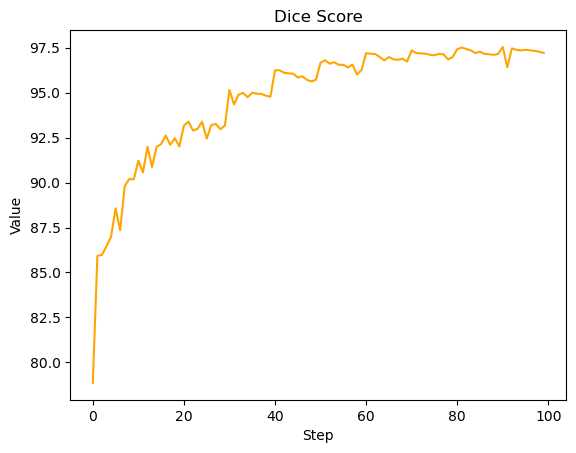

In [97]:
plot_metrics(dfDice,'Dice Score','orange')

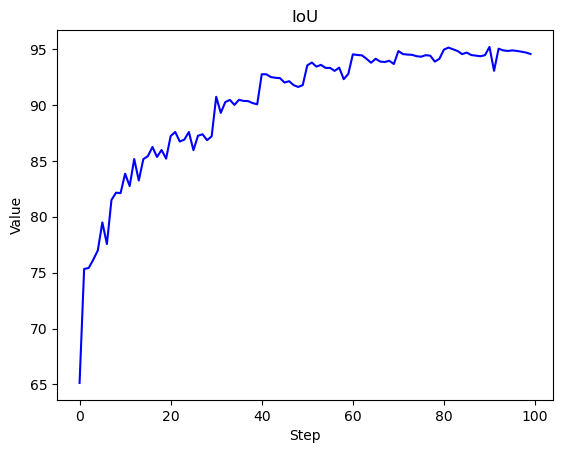

In [98]:
plot_metrics(dfIoU,'IoU','blue')